### Task 1: Project Overview and Import Modules

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

In [8]:
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.17.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon


In [9]:
data = pd.read_csv("/content/ner_files/data/ner_dataset.csv", encoding="latin1")

data = data.fillna(method="ffill")
data.head(20)

<ipython-input-9-3d911bb3fd4a>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [10]:
print("Unique sentences in corpus:", data['Sentence #'].nunique())
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique sentences in corpus: 47959
Unique words in corpus: 35177
Unique tags in corpus: 17


In [11]:
data['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [12]:
data['Tag'].value_counts()

,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


In [13]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [14]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [15]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [16]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [17]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [18]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

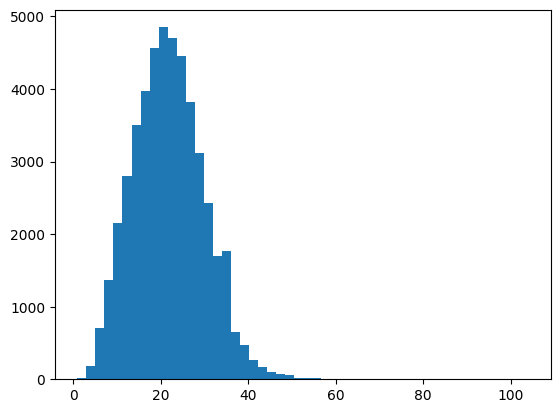

In [19]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [22]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │       1,758,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,883,117 (7.18 MB)

 Trainable params: 1,883,117 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [24]:
!pip install livelossplot

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

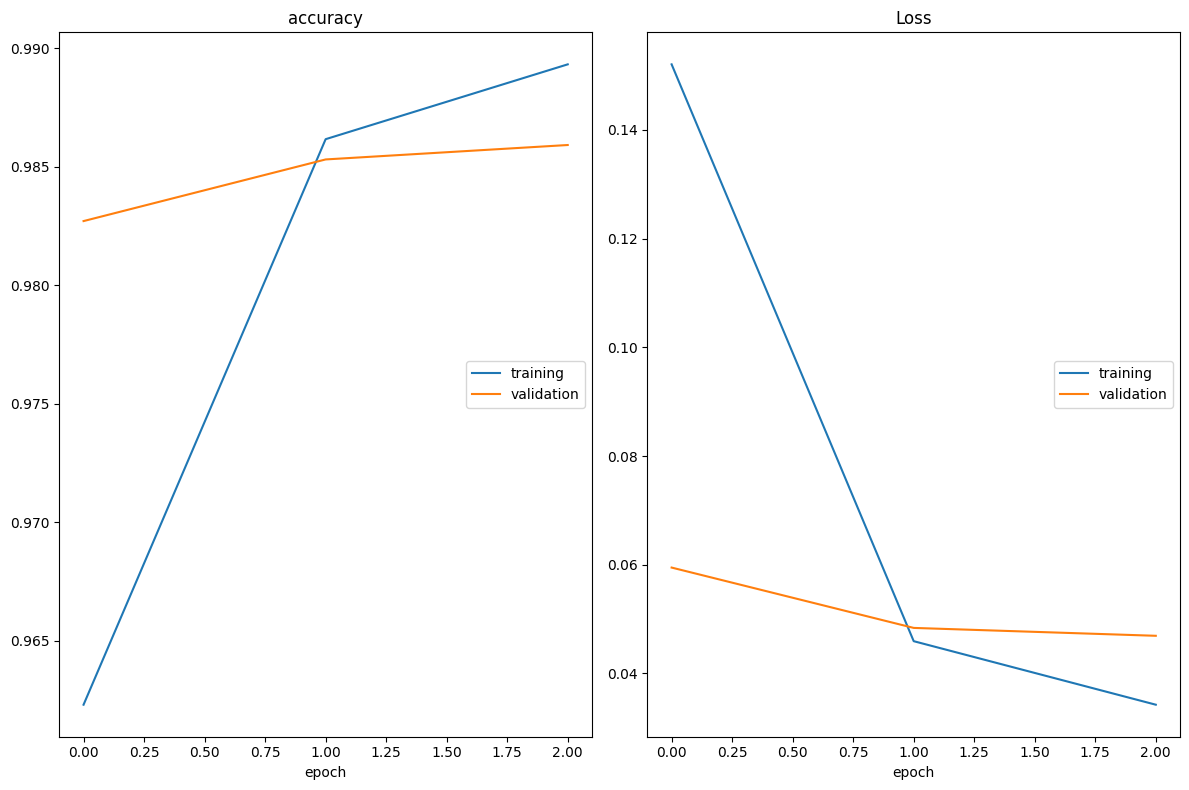

accuracy
	training         	 (min:    0.962, max:    0.989, cur:    0.989)
	validation       	 (min:    0.983, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.034, max:    0.152, cur:    0.034)
	validation       	 (min:    0.047, max:    0.059, cur:    0.047)

Epoch 3: val_loss improved from 0.04838 to 0.04693, saving model to model.weights.h5
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 205s 165ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.9859 - val_loss: 0.0469
CPU times: user 13min 57s, sys: 1min 24s, total: 15min 22s
Wall time: 11min 11s


In [30]:
%%time

chkpt = ModelCheckpoint("model.weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

## Export word2idx and tag2index

In [38]:
joblib.dump(word2idx, '/content/ner_files/model/word2idx.joblib', compress=9)
joblib.dump(tag2idx, '/content/ner_files/model/tag2idx.joblib', compress=9)

['/content/ner_files/model/tag2idx.joblib']

In [34]:
model.save("/content/ner_files/model/ner-model.keras")

### Task 8: Evaluate Named Entity Recognition Model

In [35]:
model.evaluate(x_test, y_test)

300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9857 - loss: 0.0477


[0.04693193733692169, 0.9859111309051514]

## Load trained model

In [36]:
from tensorflow.keras.models import load_model
import joblib

In [39]:
model = load_model("/content/ner_files/model/ner-model.keras")
word2idx = joblib.load("/content/ner_files/model/word2idx.joblib")
tag2idx = joblib.load("/content/ner_files/model/tag2idx.joblib")

In [40]:
def predict(text):
    max_len = 50
    str_len = len(text.split())

    text = [[word2idx.get(w, 0) for w in text.split()]]
    text = pad_sequences(maxlen=max_len, sequences=text, padding="post", value=num_words-1)
    p = model.predict(np.array([text[0]]))

    p = np.argmax(p, axis=-1)
    print("{:15}\t {}\n".format("Word", "Pred"))
    print("-" *30)
    for i in range(str_len):
        print("{:15}\t{}".format(words[text[0][i]-1], tags[p[0][i]]))

#     for w, pred in zip(text[0], p[0]):
#         print("{:15}\t{}".format(words[w-1], tags[pred]))

In [43]:
predict("Mahmoud is Egyptian living in Cairo")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Word           	 Pred

------------------------------
Mahmoud        	B-per
is             	O
Egyptian       	B-gpe
living         	O
in             	O
Cairo          	B-geo
